In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pjme-hourly1/PJME_hourly.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [4]:
df = pd.read_csv('/kaggle/input/pjme-hourly1/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


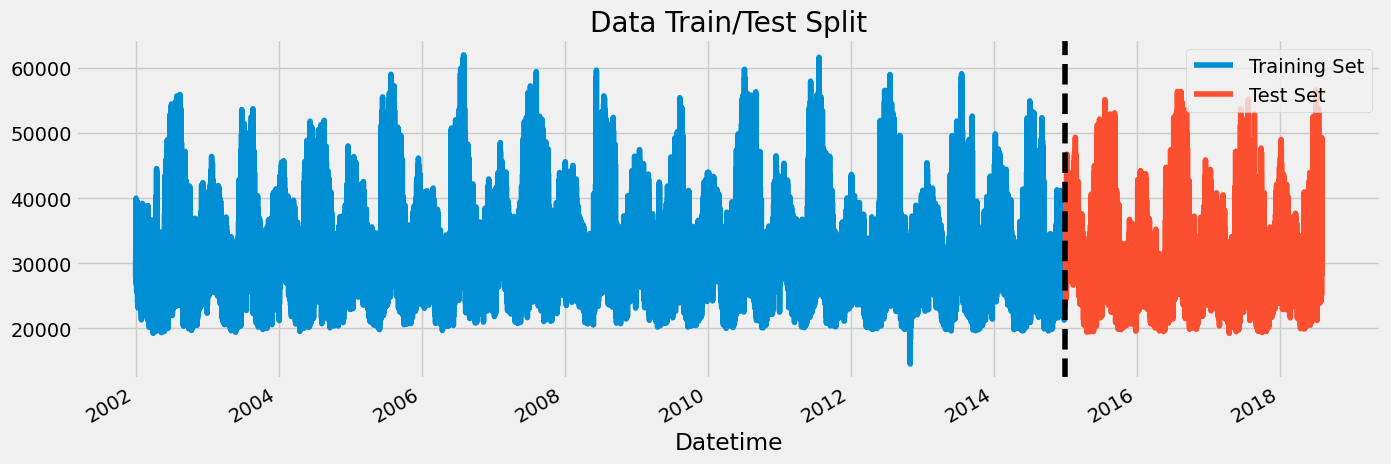

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

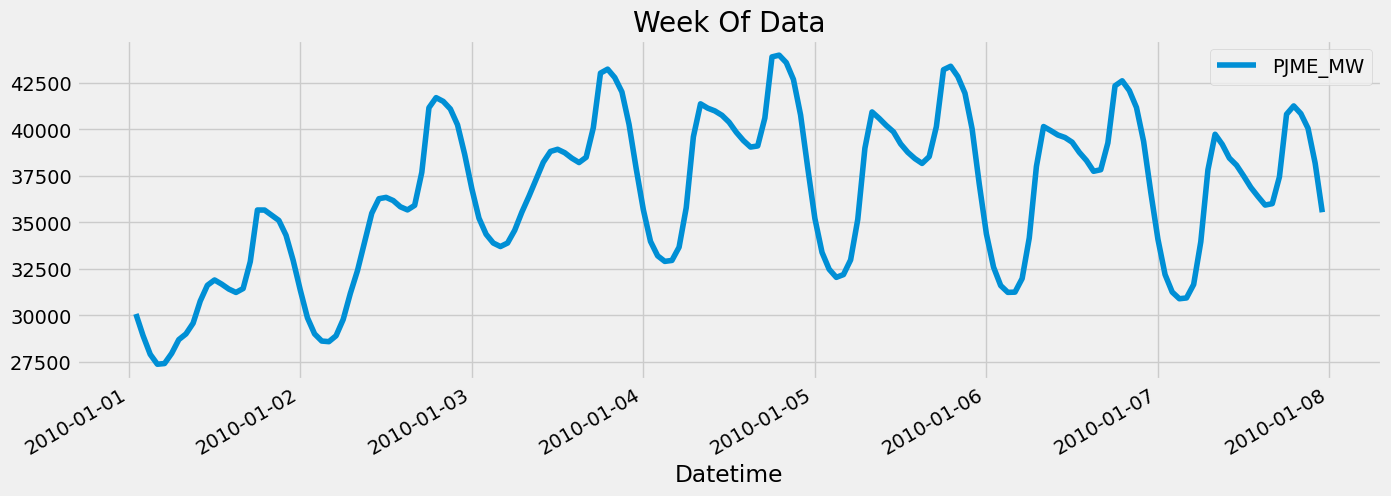

In [6]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [8]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


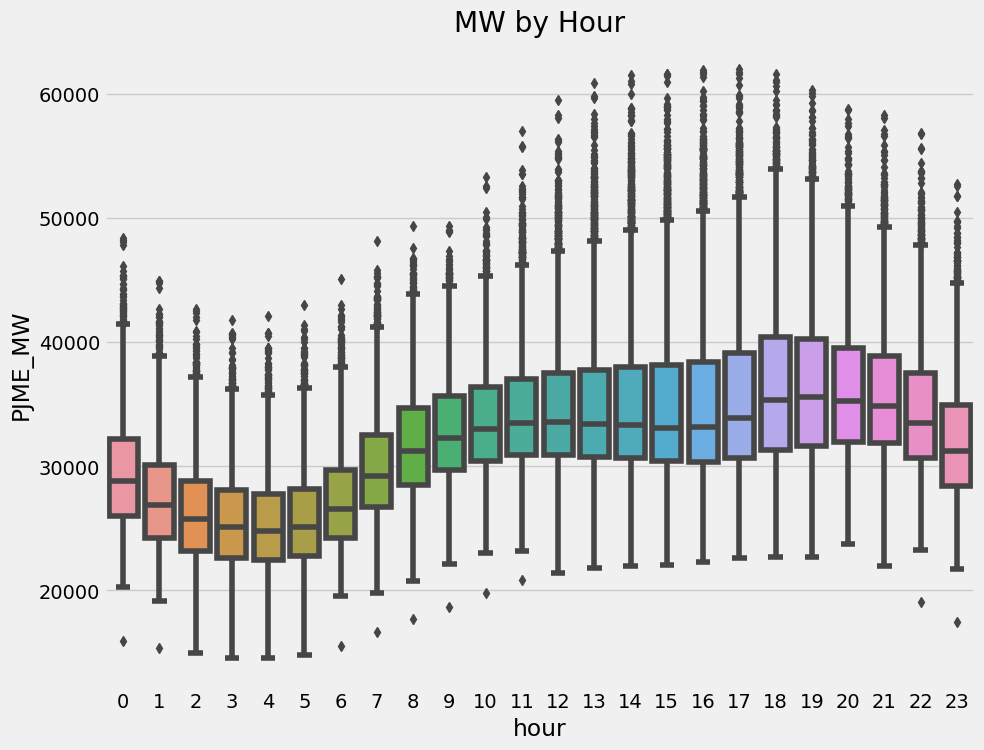

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

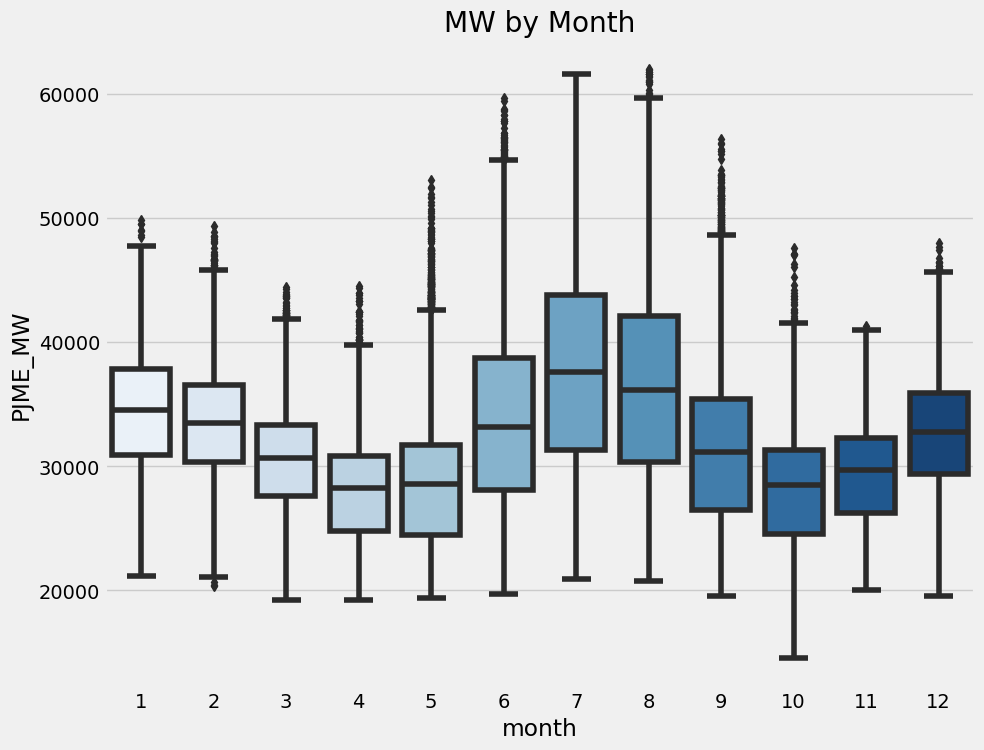

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [11]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [12]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:47:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

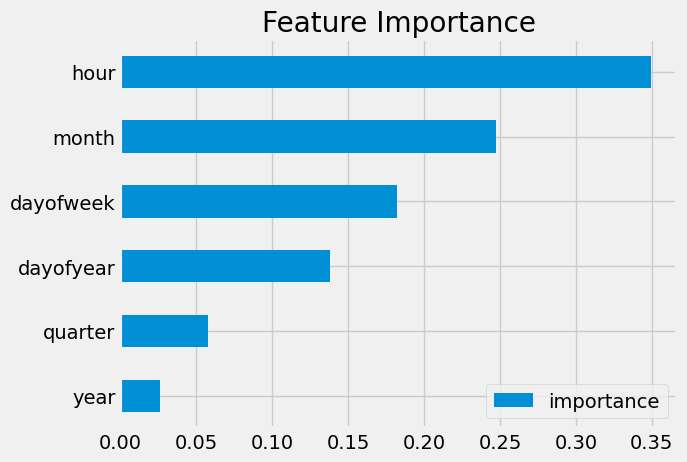

In [13]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [14]:
fi

,importance
dayofyear,0.138096
hour,0.349240
dayofweek,0.181862
quarter,0.057403
month,0.247377
year,0.026023


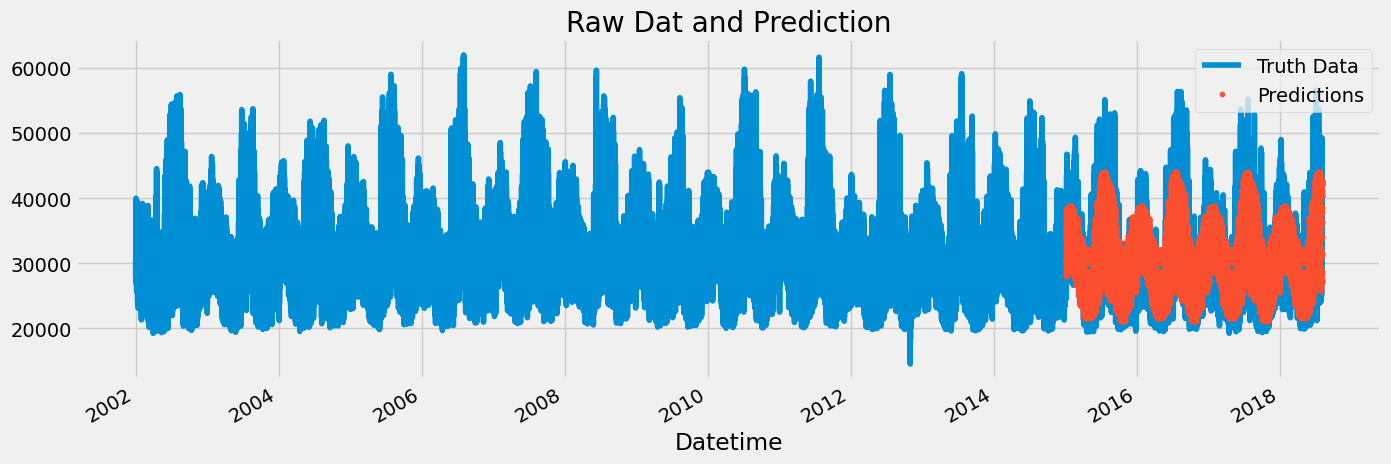

In [15]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [16]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42575.265625
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,42522.703125
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,40804.101562


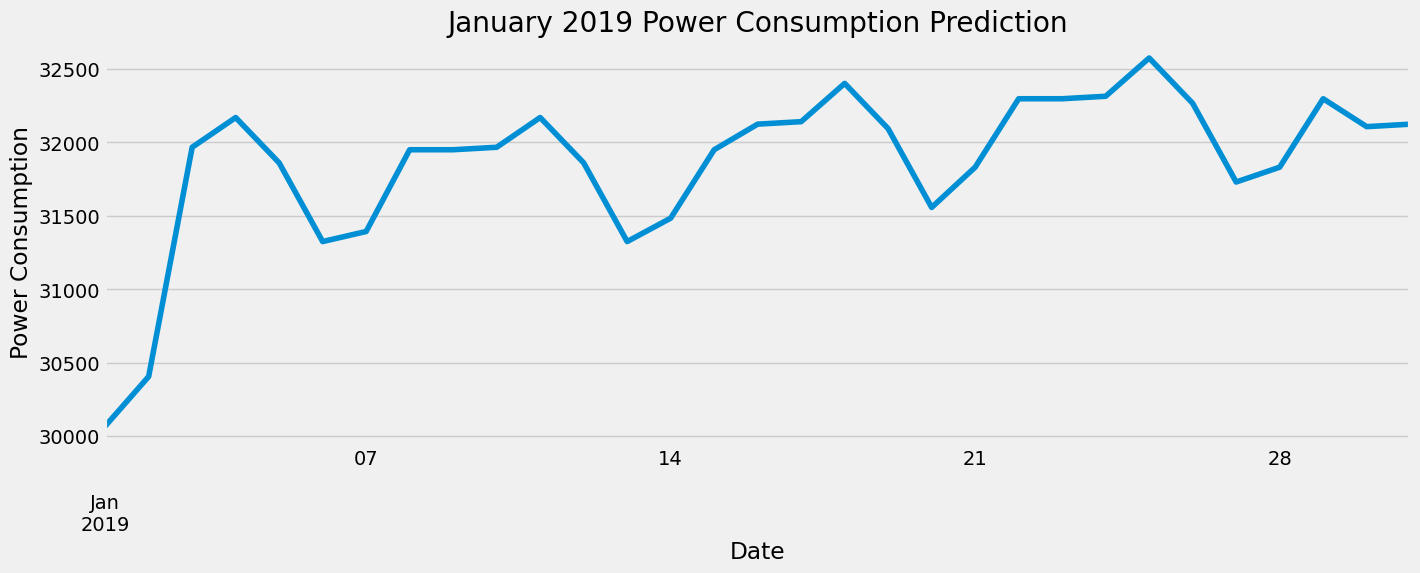

In [17]:
# Assuming 'xgb_model' is your trained XGBoost model
# Assuming 'df' is your original DataFrame used for training

# Create a new DataFrame with a datetime index for January 2019
new_data = pd.DataFrame(index=pd.date_range(start='2019-01-01', end='2019-01-31'))

# Extract relevant features from the original DataFrame
# Make sure to adjust this based on your actual feature names
new_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']] = new_data.index.to_series().apply(lambda x: pd.Series([x.dayofyear, x.hour, x.dayofweek, x.quarter, x.month, x.year]))

# Make predictions for January 2019 using the trained model
new_data['prediction'] = reg.predict(new_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']])

# Plot the predicted values
ax = new_data['prediction'].plot(figsize=(15, 5), title='January 2019 Power Consumption Prediction')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.show()



In [18]:
new_data

,dayofyear,hour,dayofweek,quarter,month,year,prediction
2019-01-01,1,0,1,1,1,2019,30068.199219
2019-01-02,2,0,2,1,1,2019,30406.078125
2019-01-03,3,0,3,1,1,2019,31966.263672
2019-01-04,4,0,4,1,1,2019,32168.689453
2019-01-05,5,0,5,1,1,2019,31860.261719
2019-01-06,6,0,6,1,1,2019,31324.591797
2019-01-07,7,0,0,1,1,2019,31393.117188
2019-01-08,8,0,1,1,1,2019,31949.460938
2019-01-09,9,0,2,1,1,2019,31949.460938
2019-01-10,10,0,3,1,1,2019,31966.263672


POWER CONSUMPTION FROM JANUARY TO MARCH 2019

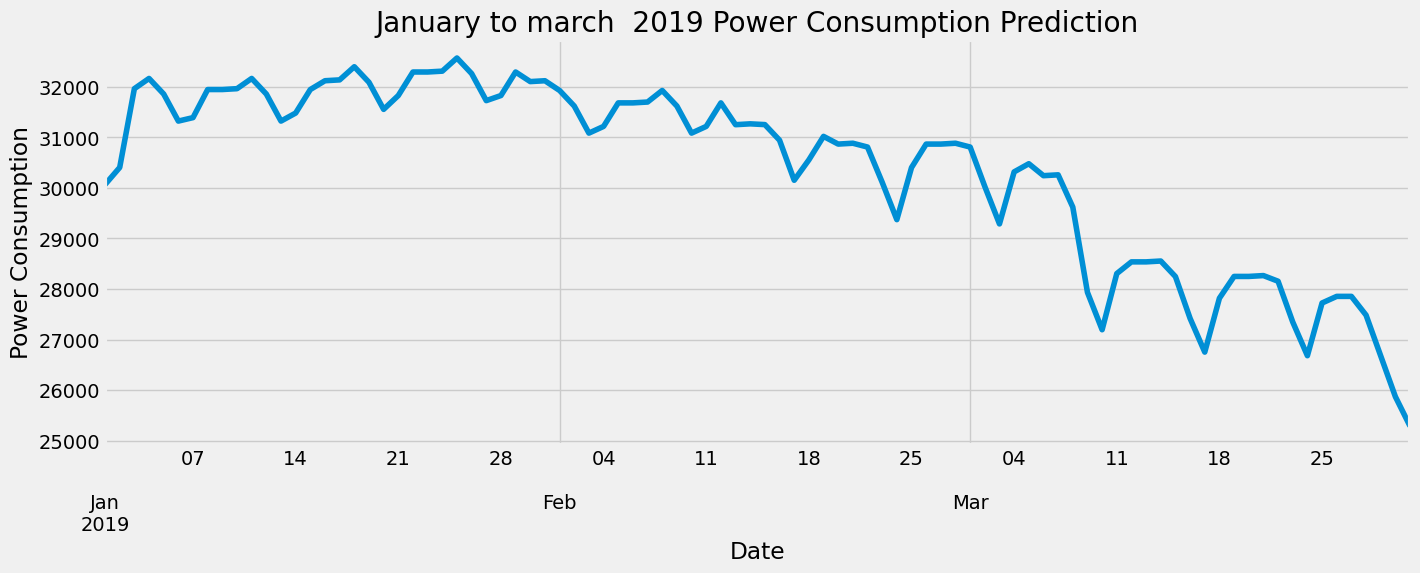

In [19]:
# Create a new DataFrame with a datetime index for January 2019
new_data = pd.DataFrame(index=pd.date_range(start='2019-01-01', end='2019-03-31'))

# Extract relevant features from the original DataFrame
# Make sure to adjust this based on your actual feature names
new_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']] = new_data.index.to_series().apply(lambda x: pd.Series([x.dayofyear, x.hour, x.dayofweek, x.quarter, x.month, x.year]))

# Make predictions for January 2019 using the trained model
new_data['prediction'] = reg.predict(new_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']])

# Plot the predicted values
ax = new_data['prediction'].plot(figsize=(15, 5), title='January to march  2019 Power Consumption Prediction')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.show()

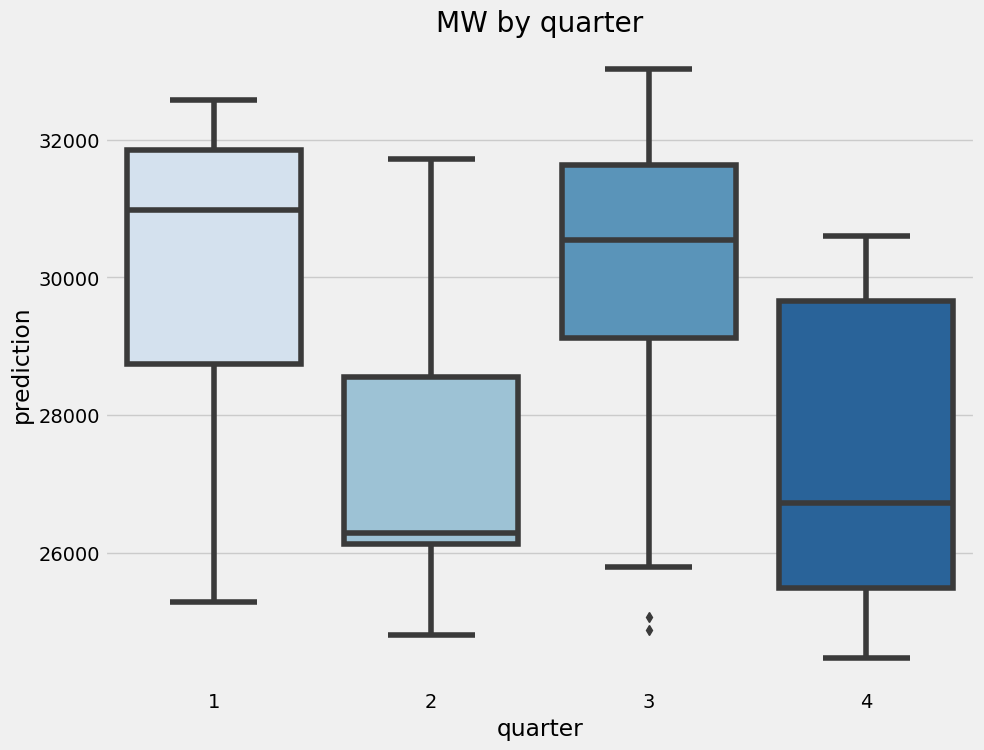

In [20]:
# Create a new DataFrame with a datetime index for January 2019
new_data = pd.DataFrame(index=pd.date_range(start='2019-01-01', end='2019-12-31'))

# Extract relevant features from the original DataFrame
# Make sure to adjust this based on your actual feature names
new_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']] = new_data.index.to_series().apply(lambda x: pd.Series([x.dayofyear, x.hour, x.dayofweek, x.quarter, x.month, x.year]))

# Make predictions for January 2019 using the trained model
new_data['prediction'] = reg.predict(new_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=new_data, x='quarter', y='prediction', palette='Blues')
ax.set_title('MW by quarter')
plt.show()

In [21]:
#TO FIND POWER CONSUMPTION OF SPECIFIC DAY

In [22]:
import pandas as pd

# Assuming 'reg' is your trained model
# Assuming you want to predict for January 15, 2019 (you can change the date)
prediction_date = pd.to_datetime('2019-01-15')

# Create a DataFrame with a single row for the prediction date
prediction_data = pd.DataFrame(index=[prediction_date])

# Extract relevant features from the prediction date
prediction_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']] = prediction_data.index.to_series().apply(lambda x: pd.Series([x.dayofyear, x.hour, x.dayofweek, x.quarter, x.month, x.year]))

# Make prediction for the specific day
predicted_power_consumption = reg.predict(prediction_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']])

# Print or use the predicted power consumption value
print(f"Predicted Power Consumption on {prediction_date}: {predicted_power_consumption[0]}")


Predicted Power Consumption on 2019-01-15 00:00:00: 31949.4609375


TO FIND POWER CONSUMPTION OF SPECIFIC TIME OF A DAY

In [ ]:
import pandas as pd

# Assuming 'reg' is your trained model
# User input for the prediction date and time
prediction_date_str = input("Enter the prediction date (YYYY-MM-DD): ")
prediction_time_str = input("Enter the prediction time (HH:MM): ")

# Convert input strings to datetime objects
prediction_datetime = pd.to_datetime(f"{prediction_date_str} {prediction_time_str}")

# Create a DataFrame with a single row for the prediction date and time
prediction_data = pd.DataFrame(index=[prediction_datetime])

# Extract relevant features from the prediction date and time
prediction_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']] = prediction_data.index.to_series().apply(lambda x: pd.Series([x.dayofyear, x.hour, x.dayofweek, x.quarter, x.month, x.year]))

# Make prediction for the specific day and time
predicted_power_consumption = reg.predict(prediction_data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']])

# Print or use the predicted power consumption value
print(f"Predicted Power Consumption on {prediction_datetime}: {predicted_power_consumption[0]}")


In [24]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 3726.80


In [26]:
print(r2_score(y_test,test['prediction']))

0.6661183856371169
